# Australia macro data

In [7]:
AUdata2y = ek.get_timeseries([   'AUPHA=ECI',       # Private house approvals 
                                 'AURSL=ECI',       # Retail sales 
                                 'AUJOBL=ECI',      # Unemployment rate 
                                 'AUBLD=ECI',       # Building approvals 
                                 'AUHCR=ECI'],      # Housing credit
                       start_date = "2000-01-01",
                       end_date = "'2020-12-31",
                       interval="monthly"
                      )

# Chow test Australia 2 year gov. yields

In [16]:
# Running the Chow test with the most promising OLS model.
y = df['AU2YT=RR'] # dependent variable
x = AUdata2y[['AUPHA=ECI','AURSL=ECI','AUJOBL=ECI','AUBLD=ECI','AUHCR=ECI']]
x = sm.add_constant(x)
model = sm.OLS(y,x.astype(float))
results = model.fit()
# Model for the first 10 years
y_1 = df['AU2YT=RR'][:126] # break in the middle of the samle
x_1 = AUdata2y[['AUPHA=ECI','AURSL=ECI','AUJOBL=ECI','AUBLD=ECI','AUHCR=ECI']][:126]
x_1 = sm.add_constant(x_1)
model = sm.OLS(y_1,x_1.astype(float))
results = model.fit()
# Model for the second 10 years
y_2 = df['AU2YT=RR'][126:]
x_2 = AUdata2y[['AUPHA=ECI','AURSL=ECI','AUJOBL=ECI','AUBLD=ECI','AUHCR=ECI']][126:]
x_2 = sm.add_constant(x_2)
model = sm.OLS(y_2,x_2.astype(float))
results = model.fit()

In [17]:
J = x.shape[1]
k = x_1.shape[1]
N1 = x_1.shape[0]
N2 = x_2.shape[0]

In [18]:
model_dummy = sm.OLS(y,x.astype(float)).fit()
RSSd = model_dummy.ssr

model_b = sm.OLS(y_1,x_1.astype(float)).fit()
RSSb = model_b.ssr

model_nb = sm.OLS(y_2,x_2.astype(float)).fit()
RSSnb = model_nb.ssr

In [19]:
chow = ((RSSd-(RSSb+RSSnb))/J)/((RSSb+RSSnb)/(N1+N2-2*k))
scipy.stats.f.cdf(chow, J, N1+N2-2*k)

0.9999999999999999

In [20]:
# p-value of 0.999 > 0.10 and 0.05 -> accept, no structural break point.

# Rolling regression AU 2y gov. yields

In [11]:
def rolling_regression(y, x, window=60): ### 60 periods in total will be analysed
    """ 
    y and x must be pandas.Series
    """
# === Clean-up ============================================================
    x = x.dropna()
    y = y.dropna()
# === Trim acc to shortest ================================================
    if x.index.size > y.index.size:
        x = x[y.index]
    else:
        y = y[x.index]
# === Verify enough space =================================================
    if x.index.size < window:
        return None
    else:
    # === Add a constant if needed ========================================
        #X = x.to_frame()
        #X['c'] = 1
    # === Loop... this can be improved ====================================
        estimate_data = []
        for i in range(window, x.index.size+1):
            X_slice = X.values[i-window:i,:] # always index in np as opposed to pandas, much faster
            y_slice = y.values[i-window:i]
            coeff = np.dot(np.dot(np.linalg.inv(np.dot(X_slice.T, X_slice)), X_slice.T), y_slice)
            estimate_data.append(coeff[0] * x.values[window-1] + coeff[1])
    # === Assemble ========================================================
        estimate = pd.Series(data=estimate_data, index=x.index[window-1:]) 
        return estimate

In [12]:
variables1=pd.DataFrame(AUdata2y[['CLOSE','AUPHA=ECI','AURSL=ECI','AUJOBL=ECI','AUBLD=ECI','AUHCR=ECI']])
variables1['const']=1
X = variables1[['AUPHA=ECI','AURSL=ECI','AUJOBL=ECI','AUBLD=ECI','AUHCR=ECI','const']] # independent
Y = variables1['CLOSE'] ### dependent

In [13]:
rolling_ols = rolling_regression(Y,X.astype(float),10)
rolling_ols=pd.DataFrame.from_dict(dict(zip(rolling_ols.index, rolling_ols.values))).T
rolling_ols.columns=["Beta_1","Beta_2","Beta_3","Beta_4","Beta_5","Beta_6"]
rolling_ols

,Beta_1,Beta_2,Beta_3,Beta_4,Beta_5,Beta_6
2000-10-31,0.024791,0.018111,0.075726,0.041491,0.033141,0.033976
2000-11-30,-0.054742,-0.075159,0.100939,-0.003699,-0.029220,-0.026668
2000-12-31,0.021464,0.004058,0.154184,0.064979,0.043221,0.045397
2001-01-31,0.048623,0.077047,-0.168113,-0.022438,0.013092,0.009539
2001-02-28,0.062790,0.101847,-0.235022,-0.034853,0.013969,0.009086
...,...,...,...,...,...,...
2020-08-31,0.003876,-0.004843,0.070357,0.025673,0.014774,0.015864
2020-09-30,0.001897,0.003631,-0.011327,-0.002439,-0.000271,-0.000488
2020-10-31,0.002026,0.004346,-0.015659,-0.003772,-0.000873,-0.001163
2020-11-30,0.001961,0.018904,-0.127225,-0.040395,-0.019217,-0.021335


<function matplotlib.pyplot.show(close=None, block=None)>

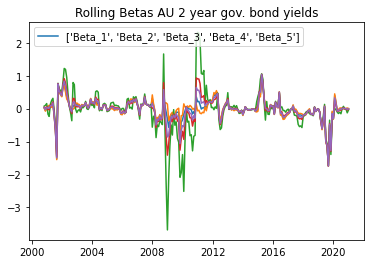

In [15]:
plt.plot(rolling_ols[['Beta_1','Beta_2','Beta_3','Beta_4','Beta_5']])
labels=[['Beta_1','Beta_2','Beta_3','Beta_4','Beta_5']]
plt.legend(labels, loc='upper left')
plt.title('Rolling Betas AU 2 year gov. bond yields')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

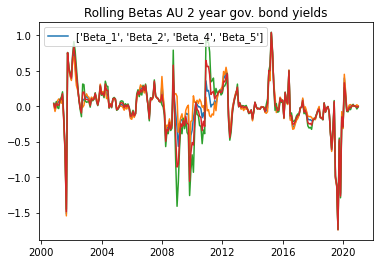

In [16]:
plt.plot(rolling_ols[['Beta_1','Beta_2','Beta_4','Beta_5']]) # without Beta_3 (unemployment rate)
labels=[['Beta_1','Beta_2','Beta_4','Beta_5']]
plt.legend(labels, loc='upper left')
plt.title('Rolling Betas AU 2 year gov. bond yields')
plt.show